<a href="https://colab.research.google.com/github/gsdxliusu/fashion-mnist/blob/main/GAN_CC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("TF version:",tf.__version__)
#算力要求比较高
print("GPU is","available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.8.0
GPU is available


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import glob
 
from IPython import display

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist #已经集成数据集
(train_images,train_labels),(test_images,test_labels) = fashion_mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images - 127.5)/127.5 #将图片标准化到[-1,1]区间内 

    

In [ ]:
buffer_size = 60000
batch_size = 256

In [ ]:
#数据打散和批次化
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)


In [ ]:
def make_generator_model():#构建生成器
    model = tf.keras.Sequential()
    #全连接层
    model.add(layers.Dense(7*7*256,use_bias = False,input_shape = (100,))) #input_shape 100维的噪音数据，dense全连接层的神经元个数
    model.add(layers.BatchNormalization())#标准化
    model.add(layers.LeakyReLU())#激活函数 
    
    
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None,7,7,256)# 做reshape
    #上采样层
    model.add(layers.Conv2DTranspose(128,(5,5),strides = (1,1),padding = 'same',use_bias = False))#反卷积，卷积核，通道数，步长，padding保持图像大小一致，偏置项
    assert model.output_shape == (None,7,7,128)
    model.add(layers.BatchNormalization())#标准化
    model.add(layers.LeakyReLU())#激活
    

    model.add(layers.Conv2DTranspose(64,(5,5),strides = (2,2),padding = 'same',use_bias = False))#步长改变
    assert model.output_shape == (None,14,14,64)#输出尺寸改变
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1,(5,5),strides = (2,2),padding = 'same',use_bias = False,activation = 'tanh'))
    assert model.output_shape == (None,28,28,1)
    
    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 12544)             1254400   
                                                                 
 batch_normalization_69 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_115 (LeakyReLU)  (None, 12544)            0         
                                                                 
 reshape_23 (Reshape)        (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_69 (Conv2D  (None, 7, 7, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_70 (Bat  (None, 7, 7, 128)      

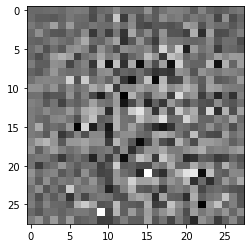

In [ ]:
noise = tf.random.normal([1,100])
generated_image = generator(noise,training = False)

plt.imshow(generated_image[0,:,:,0],cmap = 'gray')
plt.show()

In [ ]:
def make_discriminator_model():#构建判别器
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides = (2,2),padding = 'same',input_shape = [28,28,1]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128,(5,5),strides = (2,2),padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_118 (LeakyReLU)  (None, 14, 14, 64)       0         
                                                                 
 dropout_46 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_47 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_119 (LeakyReLU)  (None, 7, 7, 128)        0         
                                                                 
 dropout_47 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 flatten_23 (Flatten)        (None, 6272)            

In [ ]:
decision = discriminator(generated_image)
print(decision)


tf.Tensor([[-0.00346608]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)#二元交叉熵

In [ ]:
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss+fake_loss
    print(total_loss)
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)#定义优化器

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,discriminator_optimizer = discriminator_optimizer,generator = generator,discriminator = discriminator)

In [ ]:
epochs = 100
noise_dim = 100
num_examples_to_generate = 16

gen_loss_eva = []
disc_loss_eva = []
gen_loss_all = []
disc_loss_all = []

In [ ]:
#产生随机种子作为输入，产生矩阵，可比性
seed = tf.random.normal([num_examples_to_generate,noise_dim])

In [ ]:
#@tf.function#以静态图模式进行编译，方便迁移。
def train_step(images):#针对一组样本做一次优化
    

    noise = tf.random.normal([batch_size,noise_dim])#输入噪音
    
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training = True)#根据噪音产生图片
        
        real_output = discriminator(images,training = True)
        fake_output = discriminator(generated_images,training = True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
        
        
        gen_loss_all.append(gen_loss.numpy())
        disc_loss_all.append(disc_loss.numpy())
       
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model,epoch,test_input):#将生成的图片可视化
    predictions = model(test_input,training = False)
    
    fig = plt.figure(figsize = (4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap = 'gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
def train(dataset,epoch):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:#将图片进行分批训练
            train_step(image_batch)
        gen_loss_eva.append(sum(gen_loss_all)/len(gen_loss_all))
        print(len(gen_loss_all))
        disc_loss_eva.append(sum(disc_loss_all)/len(disc_loss_all))
        display.clear_output(wait = True)
        generate_and_save_images(generator,epoch+1,seed)
        
        if(epoch+1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print('Time for epoch{} is {} sec'.format(epoch+1,time.time()-start))

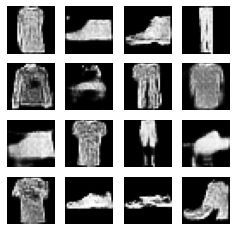

Time for epoch100 is 25.153259754180908 sec
CPU times: user 23min 21s, sys: 38 s, total: 23min 59s
Wall time: 42min 16s


In [ ]:
%%time
train(train_dataset,epochs)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:

disc_loss_eva



[1.2029703409113783,
 1.2667778210437044,
 1.2289926807931129,
 1.2434368960400846,
 1.2642815182056832,
 1.271463569258967,
 1.2763382904435363,
 1.2724897940108117,
 1.261463867039827,
 1.2557605077104366,
 1.2437991422656887,
 1.2340891436693515,
 1.225426230844226,
 1.2175370822742717,
 1.1994118874969213,
 1.1838323396254093,
 1.1638864407103708,
 1.144664731346969,
 1.1283418109675938,
 1.1128452196273397,
 1.0947302860571138,
 1.0817317170953842,
 1.066996052213337,
 1.049794304413153,
 1.0381444479759703,
 1.02839449616774,
 1.0189420321121097,
 1.0092524023539753,
 1.002754653903901,
 0.9945543043706434,
 0.988255383118261,
 0.984120055902353,
 0.9799482245163945,
 0.9751875309718864,
 0.9696275039175724,
 0.9640243027614646,
 0.9594384766468171,
 0.9535814131394212,
 0.9510128133978534,
 0.948738983802973,
 0.9451252545571786,
 0.9427529281728053,
 0.9407012644674092,
 0.9390713340856812,
 0.937543996549949,
 0.9370343927786816,
 0.9346074387491856,
 0.9327878192727659,
 0.92

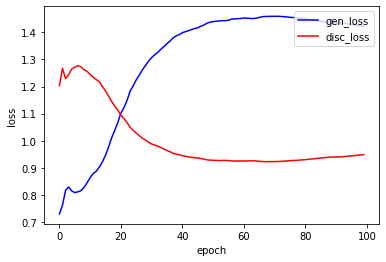

In [ ]:
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(gen_loss_eva,'blue',label = "gen_loss")
plt.plot(disc_loss_eva,'red',label = "disc_loss")
plt.legend(loc = 1)

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

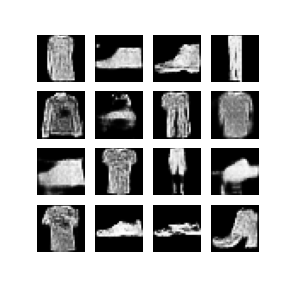

In [ ]:
display_image(epochs)

In [ ]:
import imageio
import glob
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file,mode = 'I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
